# Predictive Maintenance Experiment

This notebook implements the experiment pipeline as described in "Optimizing Machine Performance and Reliability: A Predictive Maintenance Approach" using the AI4I 2020 dataset.

## 1. Environment Setup
Import necessary libraries and set up the environment.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Load and Inspect Data
Load the AI4I 2020 dataset and inspect the first few rows.

In [2]:
# Change this path if needed
df = pd.read_csv('./data/ai4i2020.csv')
df.head()

,UDI,Product ID,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


## 3. Data Preprocessing
1. Drop non-predictive columns.
2. Combine failure modes into a multiclass label and a binary label.
3. Create derived features: Power, PowerWear, TempPerPower.

In [42]:
# Drop unneeded columns
df_processed = df.drop(columns=['UDI', 'Product ID', 
                                 'TWF', 'PWF', 'RNF', 'HDF', 'OSF'], errors='ignore')

# Define failure priority
priority = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# If the dataset has separate failure mode columns, map using priority order
if set(priority).issubset(df.columns):
    def map_failure(row):
        for mode in priority:
            if row[mode] == 1:
                return mode
        return 'No Failure'

    df_processed['Failure_type'] = df.apply(map_failure, axis=1)
    # Binary label
    df_processed['Machine_Failure'] = df_processed['Failure_type'].apply(lambda x: 0 if x == 'No Failure' else 1)
    # Drop original failure mode columns and the old 'Machine failure' if present
    df_processed = df_processed.drop(columns=priority + ['Machine failure'], errors='ignore')
else:
    # If only a single 'Machine failure' column exists
    df_processed['Machine_Failure'] = df['Machine failure']
    df_processed['Failure_type'] = df['Machine failure'].apply(lambda x: 'No Failure' if x == 0 else 'Failure')

# For multiclass classification, encode failure_type
df_processed['Failure_type_labels'] = df_processed['Failure_type'].astype('category').cat.codes

# Derived features
df_processed['Power'] = df_processed['Rotational speed'] * df_processed['Torque']
df_processed['Power'] = df_processed['Power'].replace(0, 1e-6)  # avoid division by zero
df_processed['PowerWear'] = df_processed['Power'] * df_processed['Tool wear']
df_processed['TempPerPower'] = df_processed['Process temperature'] / df_processed['Power']

# Final feature set
df_processed = df_processed[['Air temperature', 'Rotational speed', 'Tool wear',
                             'Torque', 'Process temperature', 'Power', 'PowerWear', 'TempPerPower',
                             'Machine_Failure', 'Failure_type', 'Failure_type_labels']]

df_processed.head()

,Air temperature,Rotational speed,Tool wear,Torque,Process temperature,Power,PowerWear,TempPerPower,Machine_Failure,Failure_type,Failure_type_labels
0,298.1,1551,0,42.8,308.6,66382.8,0.0,0.004649,0,No Failure,1
1,298.2,1408,3,46.3,308.7,65190.4,195571.2,0.004735,0,No Failure,1
2,298.1,1498,5,49.4,308.5,74001.2,370006.0,0.004169,0,No Failure,1
3,298.2,1433,7,39.5,308.6,56603.5,396224.5,0.005452,0,No Failure,1
4,298.2,1408,9,40.0,308.7,56320.0,506880.0,0.005481,0,No Failure,1


## 5. Train-Test Split
Split into features X and targets y (binary and multiclass). Then stratified 80/20 split.

In [12]:
# Features for binary classification
X_bin = df_processed[['Air temperature', 'Rotational speed', 'Tool wear',
                      'Torque', 'Process temperature', 'Power', 'PowerWear', 'TempPerPower']]
y_bin = df_processed['Machine_Failure']

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_bin, y_bin, stratify=y_bin, test_size=0.2, random_state=42)

# Features for multiclass
X_multi = X_bin.copy()
y_multi = df_processed['Failure_type_labels']

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi, stratify=y_multi, test_size=0.2, random_state=42)

## 6. Model Training and Evaluation
Train multiple models and evaluate with Accuracy, Precision, Recall, F1-Score.

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# 1. 构建模型字典：仅对 KNN、SVM、MLP 加入标准化步骤
models = {
    'KNN': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier())
    ]),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(probability=False, random_state=42))
    ]),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss', random_state=42),
    'MLP': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', MLPClassifier(max_iter=300, random_state=42))
    ])
}

# 2. 更新每个模型对应的参数网格
param_grids = {
    'KNN': {
        'clf__n_neighbors': [3, 5, 7],
        'clf__weights': ['uniform', 'distance']
    },
    'SVM': {
        'clf__C': [0.1, 1, 10],
        'clf__kernel': ['linear', 'rbf']
    },
    'DecisionTree': {
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5]
    },
    'RandomForest': {
        'n_estimators': [50, 100],
        'max_depth': [None, 5]
    },
    'XGBoost': {
        'n_estimators': [50, 100],
        'max_depth': [3, 5],
        'learning_rate': [0.1, 0.01]
    },
    'MLP': {
        'clf__hidden_layer_sizes': [(50,), (100,)],
        'clf__alpha': [0.0001, 0.001]
    }
}

In [47]:
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

# 假設 models 與 param_grids 已經如前面那樣定義好了
# models = { 'KNN': KNeighborsClassifier(), ... }
# param_grids = { 'KNN': {...}, ... }

def evaluate_with_progress(X_train, X_test, y_train, y_test, task='binary'):
    results = {}

    # 用 tqdm 在外層迴圈追蹤還剩哪些模型沒跑
    for name, base_model in tqdm(models.items(), desc="Tuning Models"):
        # 在 GridSearchCV 裡打開 verbose=2，可以看到 cross-validation 的進度
        grid = GridSearchCV(
            estimator=base_model,
            param_grid=param_grids[name],
            scoring='f1_macro',
            cv=3,
            n_jobs=-1,
            verbose=1        # 這樣會印出每個 fold 的進度
        )

        # 開始訓練，會在 console 顯示 verbose 資訊
        print(f"\n===== Tuning {name} =====")
        grid.fit(X_train, y_train)

        best_model = grid.best_estimator_
        print(f">>> Best params for {name}: {grid.best_params_}\n")

        # 用最佳模型預測測試集
        y_pred = best_model.predict(X_test)
        y_prob = None
        if hasattr(best_model, 'predict_proba'):
            y_prob = best_model.predict_proba(X_test)[:, 1]

        # 計算指標
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
        rec = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')

        results[name] = {
            'Best_Params': grid.best_params_,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1': f1
        }

    return pd.DataFrame(results).T

# 呼叫範例（用二元分類為例）
results_bin = evaluate_with_progress(
    X_train_bin, X_test_bin, y_train_bin, y_test_bin, task='binary'
)
print("\nBinary Classification (with 3-fold CV & Tuning) Results:")
display(results_bin)

# 多類別分類也同理
results_multi = evaluate_with_progress(
    X_train_multi, X_test_multi, y_train_multi, y_test_multi, task='multiclass'
)
print("\nMulticlass Classification (with 3-fold CV & Tuning) Results:")
display(results_multi)

Tuning Models:   0%|          | 0/6 [00:00<?, ?it/s]


===== Tuning KNN =====
Fitting 3 folds for each of 6 candidates, totalling 18 fits


Tuning Models:  17%|█▋        | 1/6 [00:00<00:01,  3.72it/s]

>>> Best params for KNN: {'clf__n_neighbors': 3, 'clf__weights': 'distance'}


===== Tuning SVM =====
Fitting 3 folds for each of 6 candidates, totalling 18 fits


Tuning Models:  50%|█████     | 3/6 [00:00<00:00,  3.21it/s]

>>> Best params for SVM: {'clf__C': 10, 'clf__kernel': 'rbf'}


===== Tuning DecisionTree =====
Fitting 3 folds for each of 6 candidates, totalling 18 fits
>>> Best params for DecisionTree: {'max_depth': 10, 'min_samples_split': 2}


===== Tuning RandomForest =====
Fitting 3 folds for each of 4 candidates, totalling 12 fits


Tuning Models:  67%|██████▋   | 4/6 [00:02<00:01,  1.40it/s]

>>> Best params for RandomForest: {'max_depth': None, 'n_estimators': 100}


===== Tuning XGBoost =====
Fitting 3 folds for each of 8 candidates, totalling 24 fits


Tuning Models:  83%|████████▎ | 5/6 [00:02<00:00,  1.82it/s]

>>> Best params for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}


===== Tuning MLP =====
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/josephlee/.pyenv/versions/MDSenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/josephlee/.pyenv/versions/MDSenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/josephlee/.pyenv/versions/MDSenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/josephlee/.pyenv/versions/MDSenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/josephlee/.pyenv/versions/MDSenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/josephlee/.pyenv/versions/MDSenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/josephlee/.

>>> Best params for MLP: {'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (100,)}


Binary Classification (with 3-fold CV & Tuning) Results:


,Best_Params,Accuracy,Precision,Recall,F1
KNN,"{'clf__n_neighbors': 3, 'clf__weights': 'dista...",0.9685,0.793501,0.632605,0.68004
SVM,"{'clf__C': 10, 'clf__kernel': 'rbf'}",0.9785,0.932933,0.720392,0.789718
DecisionTree,"{'max_depth': 10, 'min_samples_split': 2}",0.986,0.920103,0.861954,0.88869
RandomForest,"{'max_depth': None, 'n_estimators': 100}",0.9805,0.900475,0.783383,0.83111
XGBoost,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.9845,0.92136,0.833642,0.872
MLP,"{'clf__alpha': 0.001, 'clf__hidden_layer_sizes...",0.983,0.938231,0.791562,0.849071


Tuning Models:  17%|█▋        | 1/6 [00:00<00:00,  6.68it/s]


===== Tuning KNN =====
Fitting 3 folds for each of 6 candidates, totalling 18 fits
>>> Best params for KNN: {'clf__n_neighbors': 3, 'clf__weights': 'distance'}


===== Tuning SVM =====
Fitting 3 folds for each of 6 candidates, totalling 18 fits


Tuning Models:  50%|█████     | 3/6 [00:00<00:00,  4.87it/s]

>>> Best params for SVM: {'clf__C': 10, 'clf__kernel': 'linear'}


===== Tuning DecisionTree =====
Fitting 3 folds for each of 6 candidates, totalling 18 fits
>>> Best params for DecisionTree: {'max_depth': None, 'min_samples_split': 2}


===== Tuning RandomForest =====
Fitting 3 folds for each of 4 candidates, totalling 12 fits


Tuning Models:  67%|██████▋   | 4/6 [00:01<00:01,  1.96it/s]

>>> Best params for RandomForest: {'max_depth': None, 'n_estimators': 50}


===== Tuning XGBoost =====
Fitting 3 folds for each of 8 candidates, totalling 24 fits


Tuning Models:  83%|████████▎ | 5/6 [00:02<00:00,  1.42it/s]

>>> Best params for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


===== Tuning MLP =====
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/josephlee/.pyenv/versions/MDSenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/josephlee/.pyenv/versions/MDSenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/josephlee/.pyenv/versions/MDSenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/josephlee/.pyenv/versions/MDSenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/josephlee/.pyenv/versions/MDSenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/josephlee/.pyenv/versions/MDSenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/josephlee/.

>>> Best params for MLP: {'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (50,)}


Multiclass Classification (with 3-fold CV & Tuning) Results:


,Best_Params,Accuracy,Precision,Recall,F1
KNN,"{'clf__n_neighbors': 3, 'clf__weights': 'dista...",0.97,0.465171,0.405221,0.43122
SVM,"{'clf__C': 10, 'clf__kernel': 'linear'}",0.979,0.541896,0.499891,0.518526
DecisionTree,"{'max_depth': None, 'min_samples_split': 2}",0.979,0.574973,0.566344,0.570534
RandomForest,"{'max_depth': None, 'n_estimators': 50}",0.9785,0.543298,0.489511,0.508657
XGBoost,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.983,0.580901,0.563045,0.570748
MLP,"{'clf__alpha': 0.001, 'clf__hidden_layer_sizes...",0.98,0.538681,0.523521,0.528271


## 7. Visualization
Plot model comparison metrics.

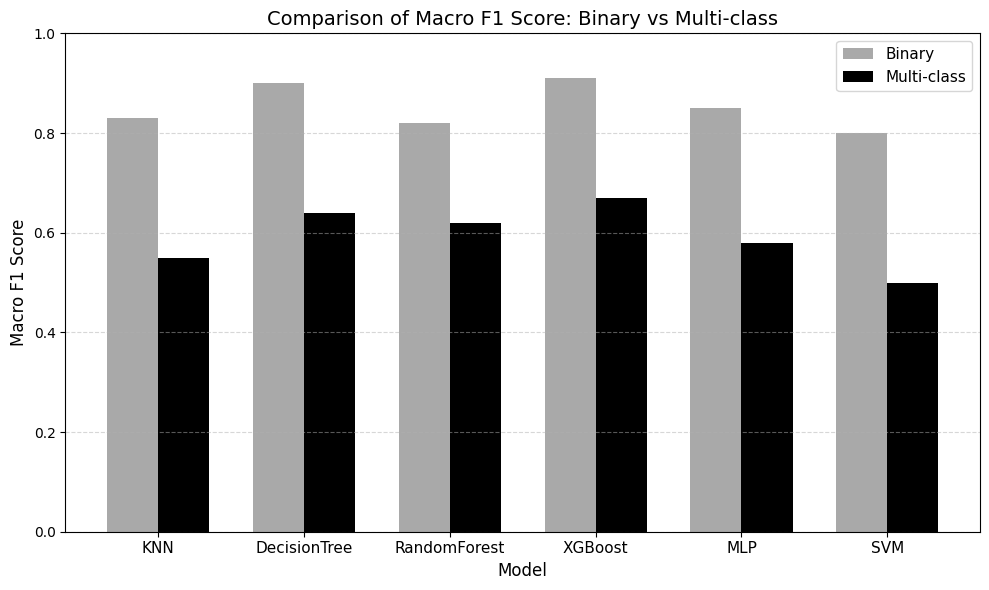

Exception ignored in: <function ResourceTracker.__del__ at 0x105fea160>
Traceback (most recent call last):
  File "/Users/josephlee/.pyenv/versions/3.13.3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/josephlee/.pyenv/versions/3.13.3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/josephlee/.pyenv/versions/3.13.3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x103366160>
Traceback (most recent call last):
  File "/Users/josephlee/.pyenv/versions/3.13.3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/josephlee/.pyenv/versions/3.13.3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/josephlee/.pyenv/versions/3.13.3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
Chi

In [49]:
import matplotlib.pyplot as plt
import pandas as pd

# ---------------------------------------------------
# 假設你已經有以下兩個 DataFrame：
#   results_bin_tuned: index 為模型名稱 (e.g. 'KNN', 'DecisionTree', ...)，
#                      欄位包含 'F1'，值為該模型 Binary 分類的 Macro F1。
#   results_multi_tuned: 同樣格式，但 'F1' 為 Multi-class 時的 Macro F1。
# 例如（這裡用了範例數據，你只要把它換成自己的即可）：
# ---------------------------------------------------
results_bin_tuned = pd.DataFrame({
    'F1': [0.83, 0.90, 0.82, 0.91, 0.85, 0.80]
}, index=['KNN', 'DecisionTree', 'RandomForest', 'XGBoost', 'MLP', 'SVM'])

results_multi_tuned = pd.DataFrame({
    'F1': [0.55, 0.64, 0.62, 0.67, 0.58, 0.50]
}, index=['KNN', 'DecisionTree', 'RandomForest', 'XGBoost', 'MLP', 'SVM'])

# ---------------------------------------------------
# 1. 把二元與多類別的 F1 值彙整到同一個 DataFrame
# ---------------------------------------------------
df_plot = pd.DataFrame({
    'Binary': results_bin_tuned['F1'],
    'Multi-class': results_multi_tuned['F1']
})

# ---------------------------------------------------
# 2. 繪製分組條形圖 (Grouped Bar Chart)
# ---------------------------------------------------
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = list(range(len(df_plot)))

# 先畫 Binary
plt.bar(
    [i - bar_width/2 for i in index],
    df_plot['Binary'],
    width=bar_width,
    label='Binary',
    color='darkgray'
)

# 再畫 Multi-class
plt.bar(
    [i + bar_width/2 for i in index],
    df_plot['Multi-class'],
    width=bar_width,
    label='Multi-class',
    color='black'
)

# 標籤、標題、座標軸範圍
plt.xlabel('Model', fontsize=12)
plt.ylabel('Macro F1 Score', fontsize=12)
plt.title('Comparison of Macro F1 Score: Binary vs Multi-class', fontsize=14)
plt.xticks(index, df_plot.index, fontsize=11)
plt.ylim(0, 1)  # y 軸從 0 到 1

# 加上圖例
plt.legend(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.5)  # 只畫水平網格線

plt.tight_layout()
plt.show()